In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip
!rm -f jena_climate_2009_2016.csv.zip

--2024-02-08 23:03:19--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
s3.amazonaws.com (s3.amazonaws.com) 해석 중... 52.217.106.254, 52.217.197.88, 16.182.35.72, ...
다음으로 연결 중: s3.amazonaws.com (s3.amazonaws.com)|52.217.106.254|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 13565642 (13M) [application/zip]
저장 위치: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  1.10MB/s    / 15s      

2024-02-08 23:03:35 (890 KB/s) - ‘jena_climate_2009_2016.csv.zip’ 저장함 [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np

temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

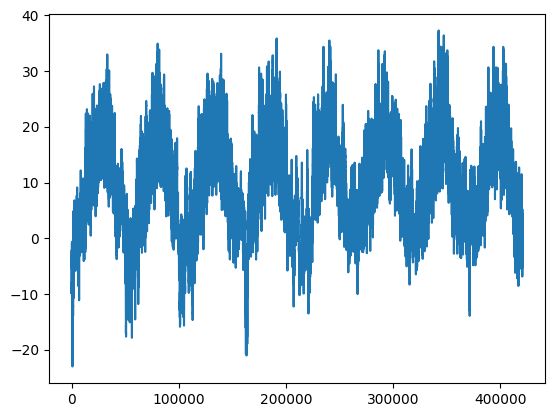

In [5]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)
plt.show()

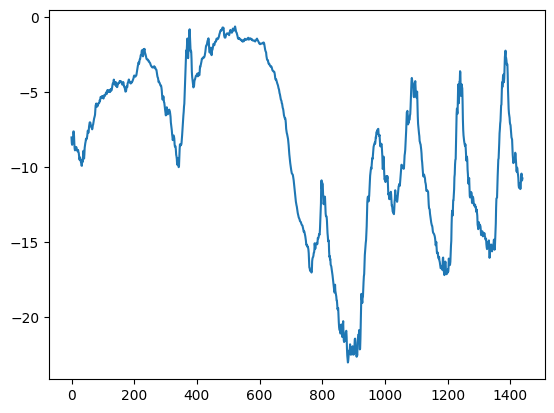

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print(f"num_train_samples: {num_train_samples}")
print(f"num_val_samples: {num_val_samples}")
print(f"num_test_samples: {num_test_samples}")

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
from tensorflow import keras

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

2024-02-12 22:56:44.180192: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-02-12 22:56:44.180236: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: yushinkim-15Z90N-VA70K
2024-02-12 22:56:44.180246: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: yushinkim-15Z90N-VA70K
2024-02-12 22:56:44.180365: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.154.5
2024-02-12 22:56:44.180395: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-02-12 22:56:44.180405: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.154.5


In [11]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


In [14]:
print(raw_data.shape)

(420451, 14)


In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_dense.keras")

print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2024-02-12 20:05:43.330151: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f54812f8950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 20:05:43.330178: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-12 20:05:43.338468: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 20:05:43.356871: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1707735943.410868   32428 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


819/819 [==============================] - 11s 12ms/step - loss: 12.3844 - mae: 2.7295 - val_loss: 12.2159 - val_mae: 2.7736
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 9.0785 - mae: 2.3695 - val_loss: 10.4149 - val_mae: 2.5593
Epoch 3/10
819/819 [==============================] - 11s 13ms/step - loss: 8.2729 - mae: 2.2637 - val_loss: 10.7383 - val_mae: 2.5872
Epoch 4/10
819/819 [==============================] - 11s 13ms/step - loss: 7.8151 - mae: 2.1985 - val_loss: 11.3994 - val_mae: 2.6764
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 7.5007 - mae: 2.1547 - val_loss: 11.0736 - val_mae: 2.6309
Epoch 6/10
819/819 [==============================] - 12s 14ms/step - loss: 7.2532 - mae: 2.1201 - val_loss: 12.7342 - val_mae: 2.8419
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 7.0357 - mae: 2.0869 - val_loss: 13.4678 - val_mae: 2.9194
Epoch 8/10
819/819 [==============================] - 12s 14ms/st

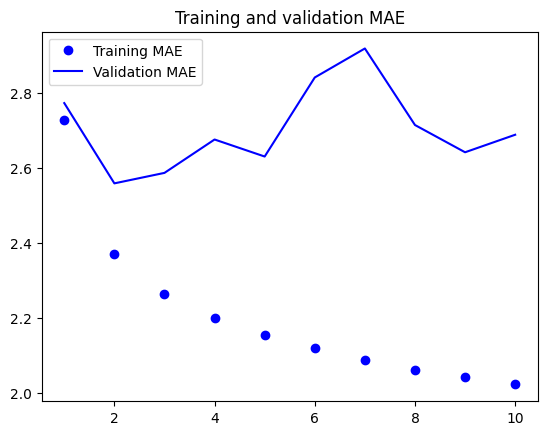

In [17]:
import matplotlib.pyplot as plt

mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, "bo", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_conv.keras")

print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 25ms/step - loss: 22.1820 - mae: 3.6722 - val_loss: 15.4321 - val_mae: 3.0973
Epoch 2/10
819/819 [==============================] - 20s 24ms/step - loss: 14.9926 - mae: 3.0639 - val_loss: 14.5700 - val_mae: 2.9986
Epoch 3/10
819/819 [==============================] - 20s 24ms/step - loss: 13.5661 - mae: 2.9101 - val_loss: 14.4064 - val_mae: 2.9937
Epoch 4/10
819/819 [==============================] - 20s 24ms/step - loss: 12.6815 - mae: 2.8109 - val_loss: 15.5620 - val_mae: 3.1032
Epoch 5/10
819/819 [==============================] - 20s 24ms/step - loss: 12.0549 - mae: 2.7387 - val_loss: 14.2256 - val_mae: 2.9446
Epoch 6/10
819/819 [==============================] - 19s 23ms/step - loss: 11.5689 - mae: 2.6808 - val_loss: 15.0101 - val_mae: 3.0372
Epoch 7/10
819/819 [==============================] - 20s 24ms/step - loss: 11.1977 - mae: 2.6386 - val_loss: 14.8067 - val_mae: 3.0118
Epoch 8/10
819/819 [============================

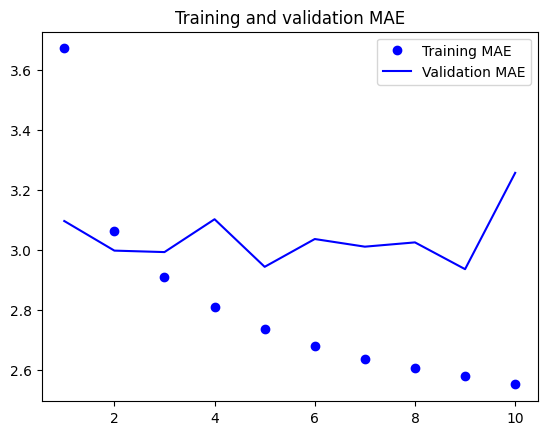

In [14]:
import matplotlib.pyplot as plt

mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, "bo", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_lstm.keras")

print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 36s 43ms/step - loss: 42.4353 - mae: 4.7269 - val_loss: 12.5763 - val_mae: 2.6911
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 10.9683 - mae: 2.5798 - val_loss: 9.5202 - val_mae: 2.3983
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 9.9058 - mae: 2.4583 - val_loss: 9.4409 - val_mae: 2.3849
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 9.4386 - mae: 2.3940 - val_loss: 9.6268 - val_mae: 2.4114
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 9.0834 - mae: 2.3448 - val_loss: 9.8722 - val_mae: 2.4284
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 8.7997 - mae: 2.3092 - val_loss: 9.8277 - val_mae: 2.4227
Epoch 7/10
819/819 [==============================] - 42s 52ms/step - loss: 8.5070 - mae: 2.2703 - val_loss: 10.0341 - val_mae: 2.4499
Epoch 8/10
819/819 [==============================] - 43s 

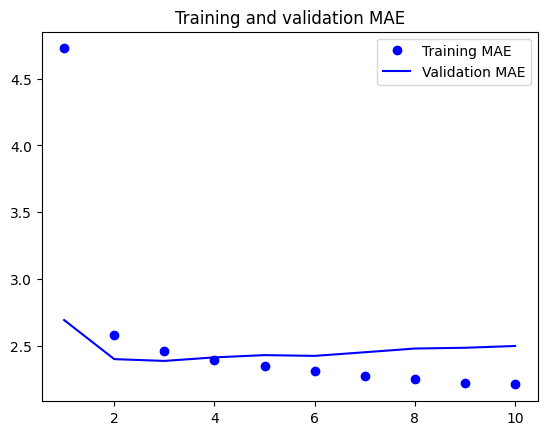

In [16]:
import matplotlib.pyplot as plt

mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, "bo", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features, ))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)